## Setup

To complete the following guide you will need to install the following packages:
- anthropic 
- voyageai
- pandas
- matplotlib
- sklearn
- numpy

You will also need:

- Anthropic API Key
- VoyageAI API Key (Optional)
    - Embeddings are pre-computed but will need API key if you make any changes

In [ ]:
!pip install anthropic
!pip install voyageai
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install -U scikit-learn

In [175]:
%env VOYAGE_API_KEY=YOUR_API_KEY

env: VOYAGE_API_KEY=YOUR_API_KEY


In [180]:
%env ANTHROPIC_API_KEY=

env: ANTHROPIC_API_KEY=


In [148]:
# Setup our environment
import anthropic
import os

client = anthropic.Anthropic(
    # This is the default and can be omitted
    api_key=os.environ.get("ANTHROPIC_API_KEY"),
)

# Classification with Claude

Large Language Models (LLMs) have revolutionized the field of classification, particularly in areas where traditional machine learning systems have faced challenges. LLMs have demonstrated remarkable success in handling classification problems characterized by complex business rules and scenarios with low-quality or limited training data. Additionally, LLMs have the capability of providing natural language explanations and justifications for their actions, enhancing the interpretability and transparency of the classification process. By leveraging the power of LLMs, we can build classification systems that go beyond the capabilities of traditional machine learning approaches and excel in scenarios where data is scarce or business requirements are intricate.

In this guide, we will explore how LLMs can be leveraged to tackle advanced classification tasks. We will cover the following key components and steps:

1. **Data Preparation**: We will begin by preparing our training and test data. The training data will be used to build the classification model, while the test data will be utilized to assess its performance. Proper data preparation is crucial to ensure the effectiveness of our classification system.

2. **Prompt Engineering**: Prompt engineering plays a vital role in harnessing the power of LLMs for classification. We will design a prompt template that defines the structure and format of the prompts used for classification. The prompt template will incorporate the user query, class definitions, and relevant examples from the vector database. By carefully crafting the prompts, we can guide the LLM to generate accurate and contextually relevant classifications.

3. **Implementing Retrieval-Augmented Generation (RAG)**: To enhance the classification process, we will employ a vector database to store and efficiently retrieve embeddings of our training data. The vector database enables similarity searches, allowing us to find the most relevant examples for a given query. By augmenting the LLM with retrieved examples, we can provide additional context and improve the accuracy of the generated classifications.

4. **Testing and Evaluation**: Once our classification system is built, we will rigorously test its performance using the transformed test data. We will iterate over the test queries, classify each query using the classification function, and compare the predicted categories with the expected categories. By analyzing the classification results, we can evaluate the effectiveness of our system and identify areas for improvement.

## Problem Definition: Insurance Support Ticket Classifier

*Note: The problem definition, data, and labels used in this example were synthetically generated by Claude 3 Opus*

In the insurance industry, customer support plays a crucial role in ensuring client satisfaction and retention. Insurance companies receive a high volume of support tickets daily, covering a wide range of topics such as billing, policy administration, claims assistance, and more. Manually categorizing these tickets can be time-consuming and inefficient, leading to longer response times and potentially impacting customer experience.

#### Category Definitions

1. Billing Inquiries
- Questions about invoices, charges, fees, and premiums
- Requests for clarification on billing statements
- Inquiries about payment methods and due dates

2. Policy Administration
- Requests for policy changes, updates, or cancellations
- Questions about policy renewals and reinstatements
- Inquiries about adding or removing coverage options

3. Claims Assistance
- Questions about the claims process and filing procedures
- Requests for help with submitting claim documentation
- Inquiries about claim status and payout timelines

4. Coverage Explanations
- Questions about what is covered under specific policy types
- Requests for clarification on coverage limits and exclusions
- Inquiries about deductibles and out-of-pocket expenses


5. Quotes and Proposals
- Requests for new policy quotes and price comparisons
- Questions about available discounts and bundling options
- Inquiries about switching from another insurer


6. Account Management
- Requests for login credentials or password resets
- Questions about online account features and functionality
- Inquiries about updating contact or personal information


7. Billing Disputes
- Complaints about unexpected or incorrect charges
- Requests for refunds or premium adjustments
- Inquiries about late fees or collection notices


8. Claims Disputes
- Complaints about denied or underpaid claims
- Requests for reconsideration of claim decisions
- Inquiries about appealing a claim outcome


9. Policy Comparisons
- Questions about the differences between policy options
- Requests for help deciding between coverage levels
- Inquiries about how policies compare to competitors' offerings


10. General Inquiries
- Questions about company contact information or hours of operation
- Requests for general information about products or services
- Inquiries that don't fit neatly into other categories




#### Labeled Data

The data can be found in this [Google Sheet](https://docs.google.com/spreadsheets/d/1UwbrWCWsTFGVshyOfY2ywtf5BEt7pUcJEGYZDkfkufU/edit#gid=563251048) you can also find the same data in the `data` folder.

We will use the following datasets:
- `./data/test.tsv`
- `./data/train/tsv`

In [150]:
import pandas as pd

data = {
    'train': [],
    'test': [],
    'test_2': []
}

# Helper function to convert a DataFrame to a list of dictionaries
def dataframe_to_dict_list(df):
    return df.apply(lambda x: {'text': x['text'], 'label': x['label']}, axis=1).tolist()


# Read the TSV file into a DataFrame
test_df = pd.read_csv("./data/test.tsv", sep='\t')
data['test'] = dataframe_to_dict_list(test_df)

train_df = pd.read_csv("./data/train.tsv", sep='\t')
data['train'] = dataframe_to_dict_list(train_df)


# Understand the labels in the dataset
labels = list(set(train_df['label'].unique()))

# Print the first training example and the number of training examples
print(data['train'][0], len(data['train']))

# Create the test set
X_test = [example['text'] for example in data['test']]
y_test = [example['label'] for example in data['test']]

# Print the length of the test set
print(len(X_test), len(y_test))


{'text': 'I just got my auto policy renewal bill and the cost seems to be more than what I usually pay. Could you explain the reason for the increase?', 'label': 'Billing Inquiries'} 68
68 68


### Evaluating each classification model

The `evaluate` function takes the following parameters:
- `X`: The input features.
- `y`: The true labels.
- `classifier`: The classifier function to be evaluated.
- `batch_size`: The size of each batch for classification (defaults to the tier's maximum batch size).

The `plot_confusion_matrix` function takes the following parameters:
- `cm`: The confusion matrix.
- `labels`: The labels for the classes.

By using this evaluation code, you can assess the performance of your classifier and visualize the confusion matrix to gain insights into the model's predictions.

Adjust the `MAXIMUM_CONCURRENT_REQUESTS` to match the rate limits associated with your Anthropic accout, [see here](https://docs.anthropic.com/claude/reference/rate-limits)

In [151]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import concurrent.futures
import numpy as np

MAXIMUM_CONCURRENT_REQUESTS = 5

def plot_confusion_matrix(cm, labels):
    # Visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set tick labels and positions
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)

    # Add labels to each cell
    thresh = cm.max() / 2.
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def evaluate(X, y, classifier, batch_size=MAXIMUM_CONCURRENT_REQUESTS):
    # Initialize lists to store the predicted and true labels
    y_true = []
    y_pred = []

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit the classification tasks to the executor in batches
        futures = []
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i+batch_size]
            batch_futures = [executor.submit(classifier, x) for x in batch_X]
            futures.extend(batch_futures)

        # Retrieve the results in the original order
        for i, future in enumerate(futures):
            predicted_label = future.result()
            y_pred.append(predicted_label)
            y_true.append(y[i])

    # Normalize y_true and y_pred
    y_true = [label.strip() for label in y_true]
    y_pred = [label.strip() for label in y_pred]

    # Calculate the classification metrics
    report = classification_report(y_true, y_pred, zero_division=1)
    cm = confusion_matrix(y_true, y_pred)
    print(report)
    plot_confusion_matrix(cm, labels)

### Random Classifier

To demonstrate the output of our evaluate function we can define a random classifier.

In [152]:
import random

def random_classifier(text):
    return random.choice(labels)

Evaluating the random classification method on the test set...
                       precision    recall  f1-score   support

   Account Management       0.12      0.17      0.14         6
     Billing Disputes       0.10      0.11      0.11         9
    Billing Inquiries       0.00      0.00      0.00         6
    Claims Assistance       0.08      0.17      0.11         6
      Claims Disputes       0.14      0.11      0.12         9
Coverage Explanations       0.17      0.11      0.13         9
    General Inquiries       0.17      0.14      0.15         7
Policy Administration       0.00      0.00      0.00         6
   Policy Comparisons       0.00      0.00      0.00         5
 Quotes and Proposals       0.17      0.20      0.18         5

             accuracy                           0.10        68
            macro avg       0.10      0.10      0.10        68
         weighted avg       0.10      0.10      0.10        68



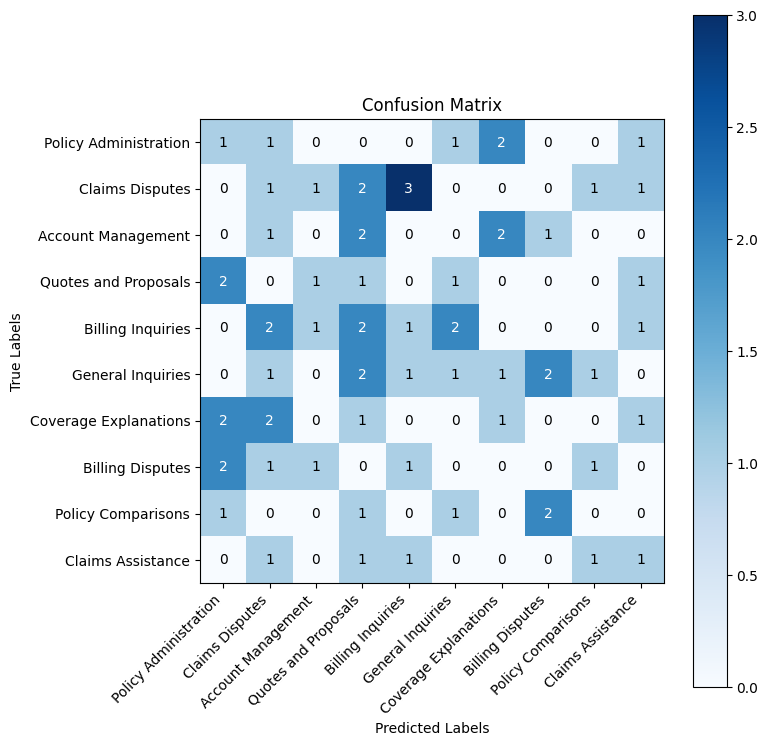

In [153]:
print("Evaluating the random classification method on the test set...")
evaluate(X_test, y_test, random_classifier)

### Simple Classification Test

Now lets construct a simple classifier using Claude.

First we will encode the categories in XML format. This will make it easier for Claude to interpret the information. Encoding information in XML is a general prompting strategy, for more information [see here](https://docs.anthropic.com/claude/docs/use-xml-tags)

In [154]:
import textwrap
categories = textwrap.dedent("""<category> 
    <label>Billing Inquiries</label>
    <content> Questions about invoices, charges, fees, and premiums Requests for clarification on billing statements Inquiries about payment methods and due dates 
    </content> 
</category> 
<category> 
    <label>Policy Administration</label>
    <content> Requests for policy changes, updates, or cancellations Questions about policy renewals and reinstatements Inquiries about adding or removing coverage options 
    </content> 
</category> 
<category> 
    <label>Claims Assistance</label> 
    <content> Questions about the claims process and filing procedures Requests for help with submitting claim documentation Inquiries about claim status and payout timelines 
    </content> 
</category> 
<category> 
    <label>Coverage Explanations</label> 
    <content> Questions about what is covered under specific policy types Requests for clarification on coverage limits and exclusions Inquiries about deductibles and out-of-pocket expenses 
    </content> 
</category> 
<category> 
    <label>Quotes and Proposals</label> 
    <content> Requests for new policy quotes and price comparisons Questions about available discounts and bundling options Inquiries about switching from another insurer 
    </content> 
</category> 
<category> 
    <label>Account Management</label> 
    <content> Requests for login credentials or password resets Questions about online account features and functionality Inquiries about updating contact or personal information 
    </content> 
</category> 
<category> 
    <label>Billing Disputes</label> 
    <content> Complaints about unexpected or incorrect charges Requests for refunds or premium adjustments Inquiries about late fees or collection notices 
    </content> 
</category> 
<category> 
    <label>Claims Disputes</label> 
    <content> Complaints about denied or underpaid claims Requests for reconsideration of claim decisions Inquiries about appealing a claim outcome 
    </content> 
</category> 
<category> 
    <label>Policy Comparisons</label> 
    <content> Questions about the differences between policy options Requests for help deciding between coverage levels Inquiries about how policies compare to competitors' offerings 
    </content> 
</category> 
<category> 
    <label>General Inquiries</label> 
    <content> Questions about company contact information or hours of operation Requests for general information about products or services Inquiries that don't fit neatly into other categories 
    </content> 
</category>""")

Next we will construct a classify function that does the following things:
- Defines the prompt template
- Inputs the variables in out prompt template
- Extracts a normalized response

Notice that we leverage the `role: assistant` message and the `stop_sequences` parameter to repeatably extract the results.

In [155]:
def simple_classify(X):
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Respond with just the label of the category between category tags.
    """).replace("{{categories}}", categories).replace("{{ticket}}", X)
    response = client.messages.create( 
        messages=[{"role":"user", "content": prompt}, {"role":"assistant", "content": "<category>"}],
        stop_sequences=["</category>"], 
        max_tokens=4096, 
        temperature=0.0,
        model="claude-3-haiku-20240307"),
    
    # Extract the result from the response
    result = response[0].content[0].text.strip()
    return result


Evaluating the simple classification method on the test set...
                       precision    recall  f1-score   support

   Account Management       1.00      1.00      1.00         6
     Billing Disputes       0.83      0.56      0.67         9
    Billing Inquiries       0.50      0.67      0.57         6
    Claims Assistance       1.00      1.00      1.00         6
      Claims Disputes       1.00      1.00      1.00         9
Coverage Explanations       0.45      1.00      0.62         9
    General Inquiries       1.00      0.00      0.00         7
Policy Administration       0.67      0.33      0.44         6
   Policy Comparisons       0.62      1.00      0.77         5
 Quotes and Proposals       1.00      0.40      0.57         5

             accuracy                           0.71        68
            macro avg       0.81      0.70      0.66        68
         weighted avg       0.80      0.71      0.67        68



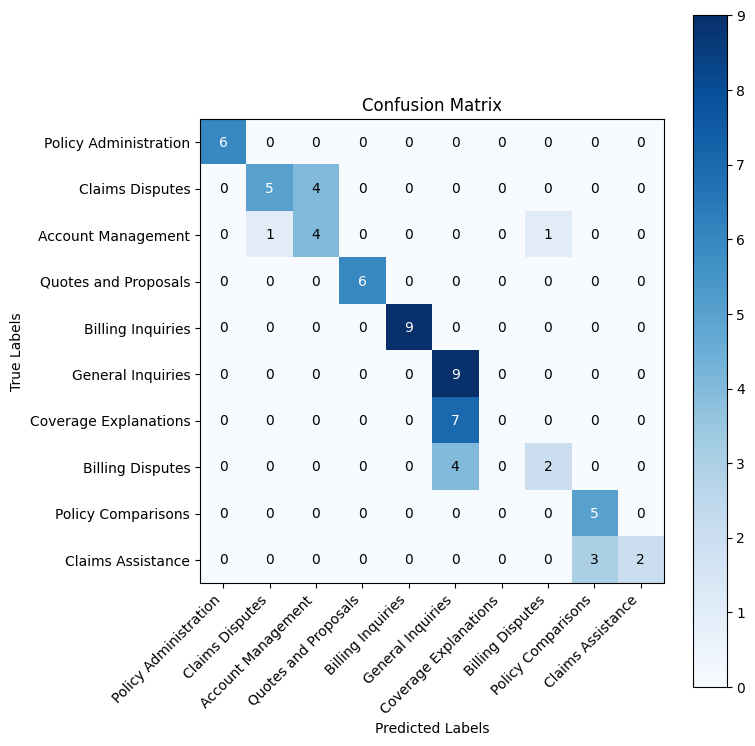

In [156]:
print("Evaluating the simple classification method on the test set...")
evaluate(X_test, y_test, simple_classify)

These results are better than random but can surely be improved! Lets add RAG with K-shot examples to the prompt.

To do this we will need to leverage a VectorDB, this will allow us to match a given query with similar examples from the training data. These examples will hopefully help increase the accuracy of our classifier

We will build a simple VectorDB class that leverages the embedding models created by [VoyageAI](https://docs.anthropic.com/en/docs/embeddings)

In [181]:
import os
import numpy as np
import voyageai
import pickle
import json

class VectorDB:
    def __init__(self, api_key=None):
        if api_key is None:
            api_key = os.getenv("VOYAGE_API_KEY")
        self.client = voyageai.Client(api_key=api_key)
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = "./data/vector_db.pkl"

    def load_data(self, data):
        # Check if the vector database is already loaded
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        # Check if vector_db.pkl exists
        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        texts = [item["text"] for item in data]

        # Embed more than 128 documents with a for loop
        batch_size = 128
        result = [
            self.client.embed(
                texts[i : i + batch_size],
                model="voyage-2"
            ).embeddings
            for i in range(0, len(texts), batch_size)
        ]

        # Flatten the embeddings
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = [item for item in data]
        self.save_db()
        # Save the vector database to disk
        print("Vector database loaded and saved.")

    def search(self, query, k=5, similarity_threshold=0.75):
        query_embedding = None
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            query_embedding = self.client.embed([query], model="voyage-2").embeddings[0]
            self.query_cache[query] = query_embedding

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
        self.save_db()
        return top_examples
    
    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

We can define the vector db and load our training data.

VoyageAI has a rate limit of 3RPM for accounts without an associated credit card. For ease of demonstration we will leverage a cache.

In [182]:
vectordb = VectorDB()
vectordb.load_data(data["train"])

Loading vector database from disk.


### RAG Classification Prompt

In this prompt we are leveraging Retrieval Augmented Generation (RAG) to insert examples from the training data that have semantically similar queries. 

In [183]:
def rag_classify(X):
    rag = vectordb.search(X,5)
    rag_string = ""
    for example in rag:
        rag_string += textwrap.dedent(f"""
        <example>
            <query>
                "{example["metadata"]["text"]}"
            </query>
            <label>
                {example["metadata"]["label"]}
            </label>
        </example>
        """)
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Use the following examples to help you classify the query:
    <examples>
        {{examples}}
    </examples>

    Respond with just the label of the category between category tags.
    """).replace("{{categories}}", categories).replace("{{ticket}}", X).replace("{{examples}}", rag_string)
    response = client.messages.create( 
        messages=[{"role":"user", "content": prompt}, {"role":"assistant", "content": "<category>"}],
        stop_sequences=["</category>"], 
        max_tokens=4096, 
        temperature=0.0,
        model="claude-3-haiku-20240307"),
    
    # Extract the result from the response
    result = response[0].content[0].text.strip()
    return result

Evaluating the RAG method on the test set...
                       precision    recall  f1-score   support

   Account Management       1.00      1.00      1.00         6
     Billing Disputes       0.82      1.00      0.90         9
    Billing Inquiries       1.00      0.67      0.80         6
    Claims Assistance       1.00      1.00      1.00         6
      Claims Disputes       1.00      1.00      1.00         9
Coverage Explanations       0.75      1.00      0.86         9
    General Inquiries       1.00      0.57      0.73         7
Policy Administration       1.00      1.00      1.00         6
   Policy Comparisons       1.00      1.00      1.00         5
 Quotes and Proposals       1.00      1.00      1.00         5

             accuracy                           0.93        68
            macro avg       0.96      0.92      0.93        68
         weighted avg       0.94      0.93      0.92        68



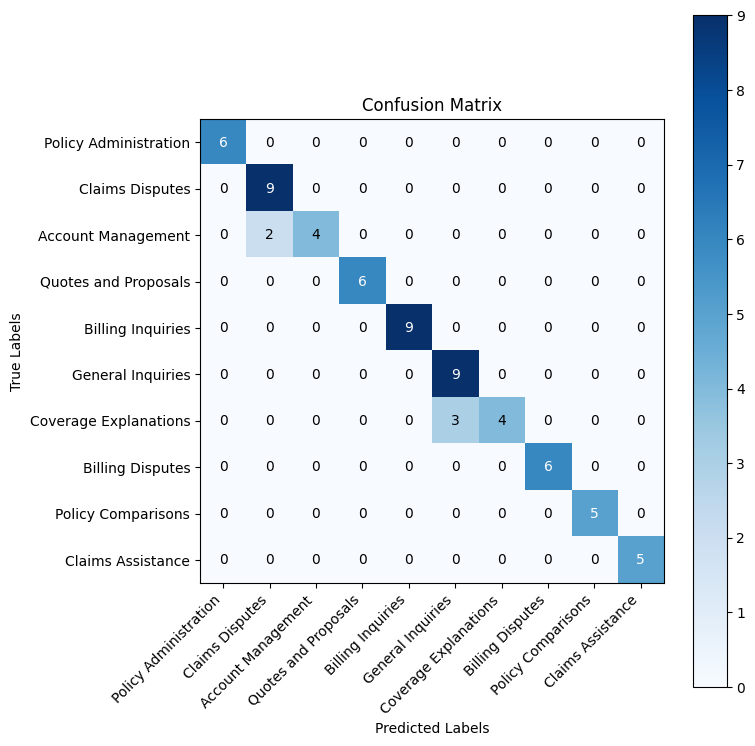

In [184]:
print("Evaluating the RAG method on the test set...")
evaluate(X_test, y_test, rag_classify)

### RAG Classification with Chain of Thought Prompt

This prompt will build on the previous, by allowing Claude to reflect on the results we can improve the accuracy of the classification.

In [185]:
def rag_chain_of_thought_classify(X):
    rag = vectordb.search(X,5)
    rag_string = ""
    for example in rag:
        rag_string += textwrap.dedent(f"""
        <example>
            <query>
                "{example["metadata"]["text"]}"
            </query>
            <label>
                {example["metadata"]["label"]}
            </label>
        </example>
        """)
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Use the following examples to help you classify the query:
    <examples>
        {{examples}}
    </examples>

    First you will think step-by-step about the problem in scratchpad tags.
    You should consider all the information provided and create a concrete argument for your classification.
    
    Respond using this format:
    <response>
        <scratchpad>Your thoughts and analysis go here</scratchpad>
        <category>The category label you chose goes here</category>
    </response>
    """).replace("{{categories}}", categories).replace("{{ticket}}", X).replace("{{examples}}", rag_string)
    response = client.messages.create( 
        messages=[{"role":"user", "content": prompt}, {"role":"assistant", "content": "<response><scratchpad>"}],
        stop_sequences=["</category>"], 
        max_tokens=4096, 
        temperature=0.0,
        model="claude-3-haiku-20240307"),
    
    # Extract the result from the response
    result = response[0].content[0].text.split("<category>")[1].strip()
    return result

Evaluating the RAG method with Chain of Thought on the test set...
                       precision    recall  f1-score   support

   Account Management       1.00      1.00      1.00         6
     Billing Disputes       0.82      1.00      0.90         9
    Billing Inquiries       1.00      0.67      0.80         6
    Claims Assistance       1.00      1.00      1.00         6
      Claims Disputes       1.00      1.00      1.00         9
Coverage Explanations       1.00      1.00      1.00         9
    General Inquiries       1.00      1.00      1.00         7
Policy Administration       1.00      1.00      1.00         6
   Policy Comparisons       1.00      1.00      1.00         5
 Quotes and Proposals       1.00      1.00      1.00         5

             accuracy                           0.97        68
            macro avg       0.98      0.97      0.97        68
         weighted avg       0.98      0.97      0.97        68



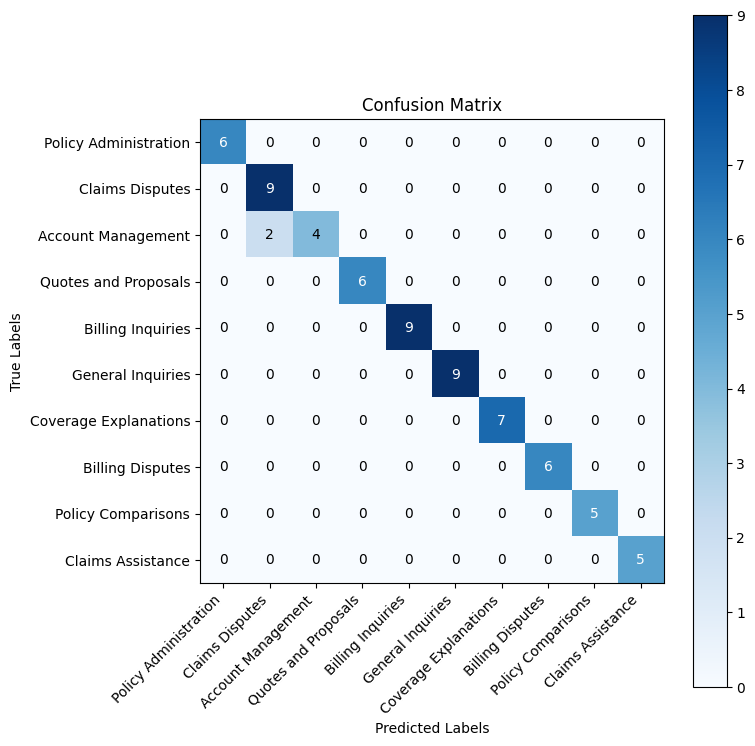

In [186]:
print("Evaluating the RAG method with Chain of Thought on the test set...")
evaluate(X_test, y_test, rag_chain_of_thought_classify)

# Evaluation

This guide has illustrated the importance of measuring prompt performance empirically when prompt engineering. You can read more about our empirical methodology to prompt engineering [here](https://docs.anthropic.com/en/docs/prompt-engineering). Using a Jupyter Notebook is a great way to start prompt engineering but as your datasets grow larger and your prompts more numerous it is important to leverage tooling that will scale with you. 

In this section of the guide we will explore using [Promptfoo](https://www.promptfoo.dev/) an open source LLM evaluation toolkit. To get started head over to the `./evaluation` directory and checkout the `./evaluation/README.md`.

When you have successfully run an evaluation come back here to view the results.

In [187]:
import json
import pandas as pd

promptfoo_results = pd.read_csv("./data/results.csv")
examples_columns = promptfoo_results.columns[2:]

number_of_providers = 5
number_of_prompts = 3

prompts = ["Simple", "RAG", "RAG w/ CoT"]

columns = ["label", "text"] + [
    json.loads(examples_columns[prompt * number_of_providers + provider])["provider"]
    + " Prompt: "
    + str(prompts[prompt])
    for prompt in range(number_of_prompts)
    for provider in range(number_of_providers)
]

promptfoo_results.columns = columns

result = (
    promptfoo_results.iloc[:, 2:]
    .astype(str)
    .apply(lambda x: x.str.count("PASS"))
    .sum()
    / len(promptfoo_results)
    * 100
).sort_values(ascending=False)

print(result)

Haiku: T-0.0 Prompt: RAG w/ CoT    95.588235
Haiku: T-0.2 Prompt: RAG w/ CoT    95.588235
Haiku: T-0.8 Prompt: RAG w/ CoT    95.588235
Haiku: T-0.0 Prompt: RAG           94.117647
Haiku: T-0.4 Prompt: RAG           94.117647
Haiku: T-0.6 Prompt: RAG           94.117647
Haiku: T-0.4 Prompt: RAG w/ CoT    94.117647
Haiku: T-0.6 Prompt: RAG w/ CoT    94.117647
Haiku: T-0.2 Prompt: RAG           92.647059
Haiku: T-0.8 Prompt: RAG           89.705882
Haiku: T-0.6 Prompt: Simple        72.058824
Haiku: T-0.0 Prompt: Simple        70.588235
Haiku: T-0.2 Prompt: Simple        70.588235
Haiku: T-0.8 Prompt: Simple        70.588235
Haiku: T-0.4 Prompt: Simple        69.117647
dtype: float64
